Tutorial 3: Adaptive Regularization
===================================

In tutorial 1, we considered why our `Constant` `Regularization` scheme was sub-optimal. Diffferent regions of the
source demand different levels of `Regularization`, motivating a `Regularization` scheme which adapts to the reconstructed
source's surface brightness.

This raises the same question as before, how do we adapt our `Regularization` scheme to the source before we've
reconstructed it? Just like in the last tutorial, we'll use a model image of a strongly lensed source from a previous
phase of the pipeline that we've begun calling the `hyper-galaxy-image`.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalSersic`.

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=3.0,
)

masked_imaging = al.MaskedImaging(
    imaging=imaging,
    mask=mask,
    settings=al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2),
)

Next, we're going to fit the image using our magnification based grid. To perform the fits, we'll use a convenience 
function to fit the lens data we simulated above.

In [3]:


def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0),
            einstein_radius=1.6,
            elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, phi=45.0),
        ),
        shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


Next, we'll use the magnification based source to fit this data.

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 673:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


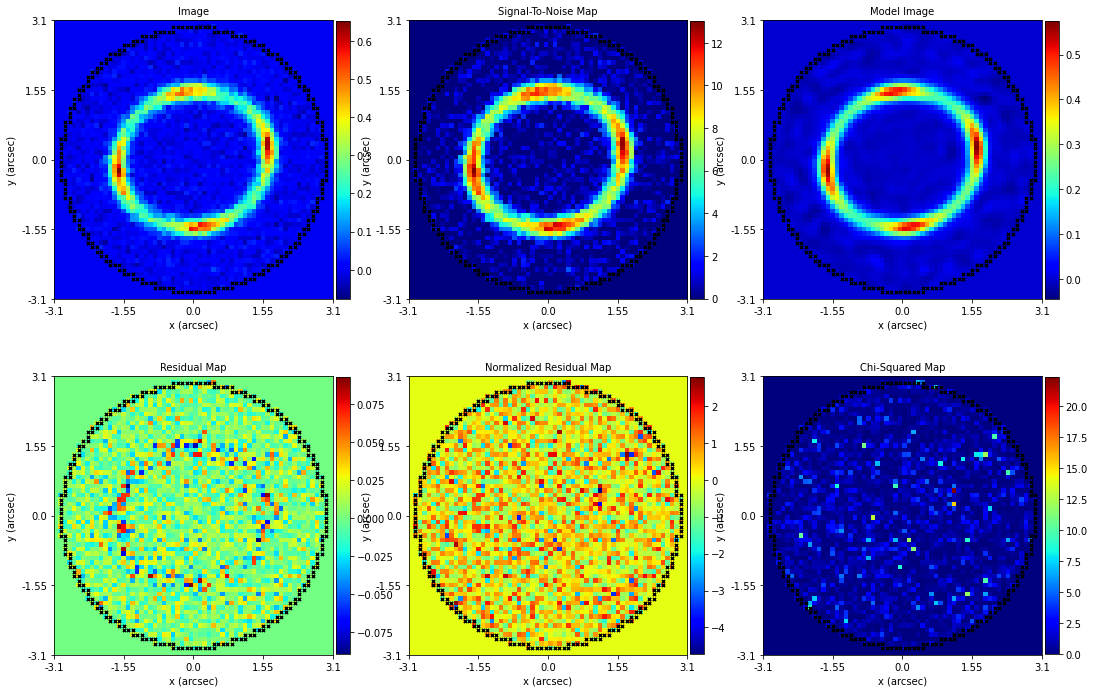

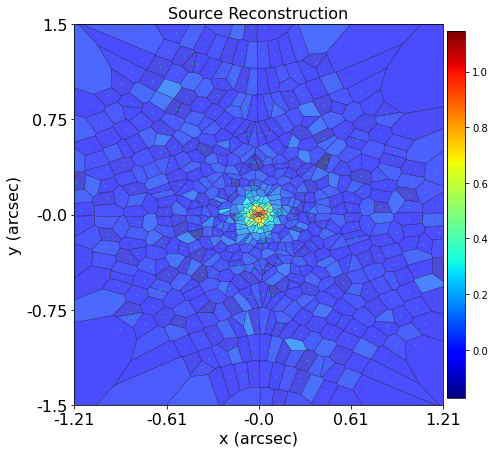

In [4]:
source_magnification = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

include_2d = aplt.Include2D(
    mask=True, mapper_data_pixelization_grid=True, mapper_source_pixelization_grid=True
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.figures_of_planes(plane_image=True, plane_index=1)

Okay, so the inversion`s fit looks just like it did in the previous tutorials. Lets quickly remind ourselves that 
the effective regularization_coefficient of each source pixel is our input coefficient value of 3.3.

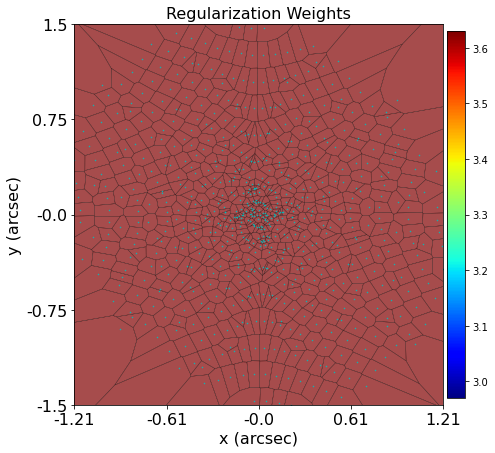

In [5]:
inversion_plotter = fit_imaging_plotter.inversion_plotter_of_plane(plane_index=1)
inversion_plotter.figures(regularization_weights=True)

Lets now look at adaptive `Regularization`.n action, by setting up a hyper-galaxy-image and using the 
`AdaptiveBrightness` `Regularization` scheme. This introduces additional hyper-galaxy-parameters, that I'll explain next.

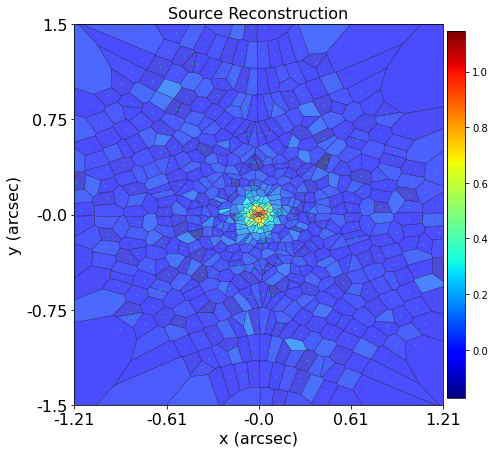

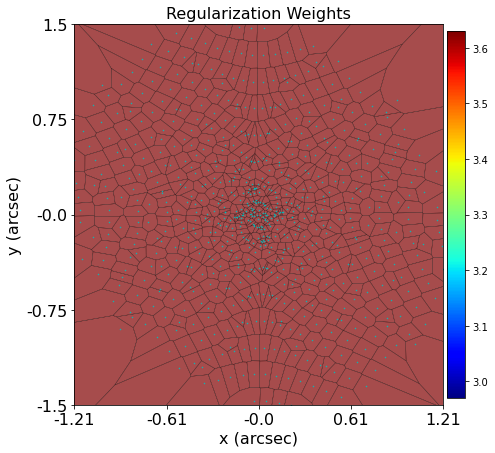

In [6]:
hyper_image = fit.model_image.slim_binned

source_adaptive_regularization = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.005, outer_coefficient=1.9, signal_scale=3.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

inversion_plotter = fit_imaging_plotter.inversion_plotter_of_plane(plane_index=1)
inversion_plotter.figures(reconstruction=True, regularization_weights=True)

So, as expected, we now have a variable `Regularization` scheme. The `Regularization`.f the source's brightest regions 
is much lower than that of its outer regions. As discussed before, this is what we want. Lets quickly check that this 
does, indeed, increase the Bayesian log evidence:

In [7]:
print("Evidence using constant `Regularization`. ", 4216)
print("Evidence using adaptive `Regularization`. ", fit.log_evidence)

Evidence using constant `Regularization`.  4216
Evidence using adaptive `Regularization`.  6370.118373036639


Yep! Of course, combining the adaptive `Pixelization` and `Regularization`.ill only further benefit our lens modeling!

However, as shown below, we don't fit the source as well as the morphology based `Pixelization` did in the last chapter. 
This is because although the adaptive `Regularization` scheme improves the fit, the magnification based 
_Pixelization_ simply *does not*  have sufficient resolution to resolve the source's cuspy central `LightProfile`.

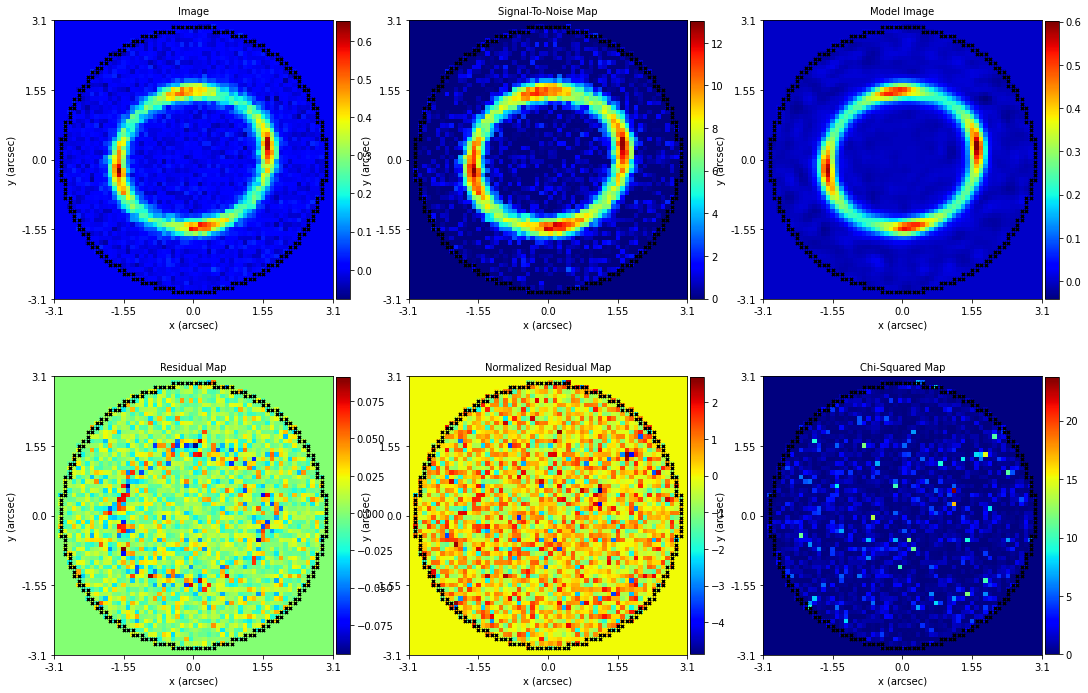

In [8]:
fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

__How does adaptive `Regularization` work?__

For every source-pixel, we have a mapping between that pixel and a set of pixels in the hyper-galaxy-image. Therefore, 
for every source-pixel, if we sum the values of all hyper-galaxy-image pixels that map to it we get an estimate of 
how much of the lensed source's signal we expect will be reconstructed. We call this each pixel`s `pixel signal`.

If a source-pixel has a higher pixel-signal, we anticipate that it`ll reconstruct more flux and we use this information 
to regularize it less. Conversely, if the pixel-signal is close to zero, the source pixel will reconstruct near-zero 
flux and `Regularization`.ill smooth over these pixels by using a high regularization_coefficient.

This works as follows:

 1) For every source pixel, compute its pixel-signal, the summed flux of all corresponding image-pixels in the 
 hyper-galaxy-image.
    
 2) Divide every pixel-signal by the number of image-pixels that map directly to that source-pixel. In doing so, all 
 pixel-signals are `relative`. This means that source-pixels which by chance map to more image-pixels than their 
 neighbors will not have a higher pixel-signal, and visa versa. This ensures the specific _Pixelization_
 does impact the adaptive `Regularization` pattern.
    
 3) Divide the pixel-signals by the maximum pixel signal so that they range between 0.0 and 1.0.
    
 4) Raise these values to the power of the hyper-galaxy-parameter *signal_scale*. For a *signal_scale* of 0.0, all 
 pixels will therefore have the same final pixel-scale. As the *signal_scale* increases, a sharper transition of 
 pixel-signal values arises between regions with high and low pixel-signals.
    
 5) Compute every source pixel`s effective regularization_coefficient as:
    
 (inner_coefficient * pixel_signals + outer_coefficient * (1.0 - pixel_signals)) ** 2.0
    
 This uses two regularization_coefficients, one which is applied to pixels with high pixel-signals and one to 
 pixels with low pixel-signals. Thus, pixels in the inner regions of the source may be given a lower level of 
 `Regularization`.han pixels further away, as desired.

Thus, we now adapt our `Regularization` scheme to the source's surface brightness. Where its brighter (and therefore 
has a steeper flux gradient) we apply a lower level of `Regularization` than further out. Furthermore, in the edges of 
the source-plane where no source-flux is present we will assume a high regularization_coefficients that smooth over 
all source-pixels.

Try looking at a couple of extra solutions which use with different inner and outer regularization_coefficients or 
signal scales. I doubt you'll notice a lot change visually, but the log evidence certainly has a lot of room for 
manoveur with different values.

You may find solutions that raise an `InversionException`. These solutions mean that the matrix used during the 
linear algebra calculation was ill-defined, and could not be inverted. These solutions are removed by **PyAutoLens** 
during lens modeling.

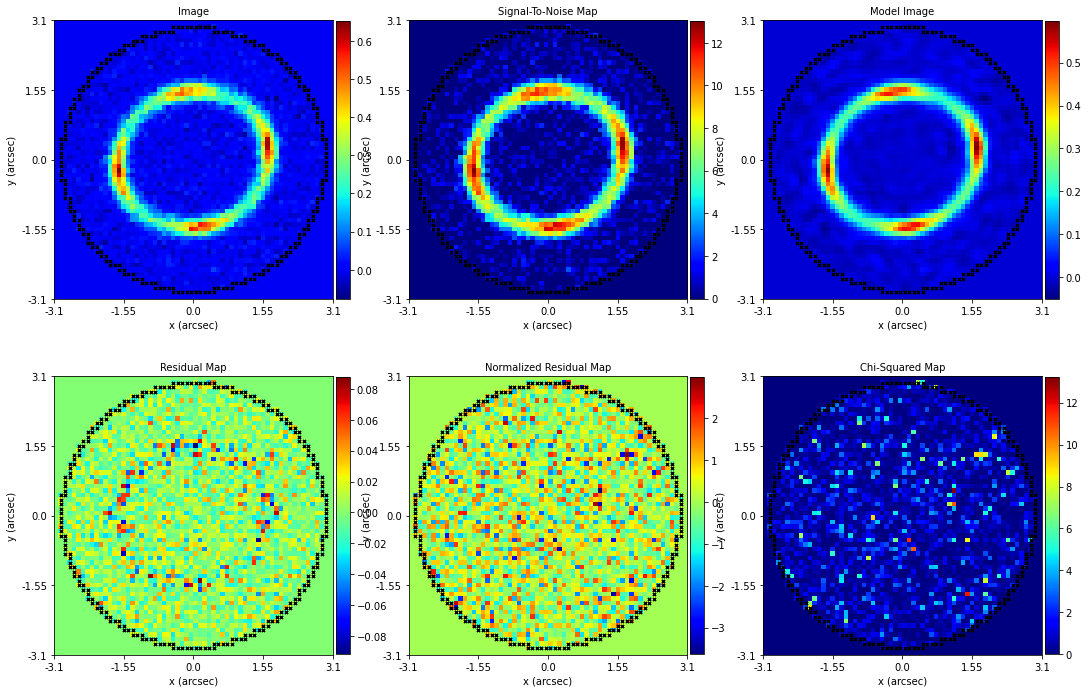

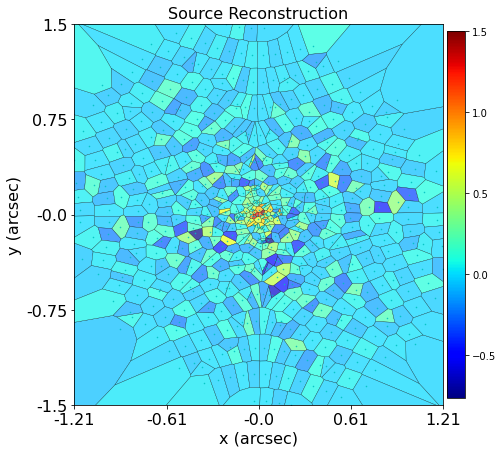

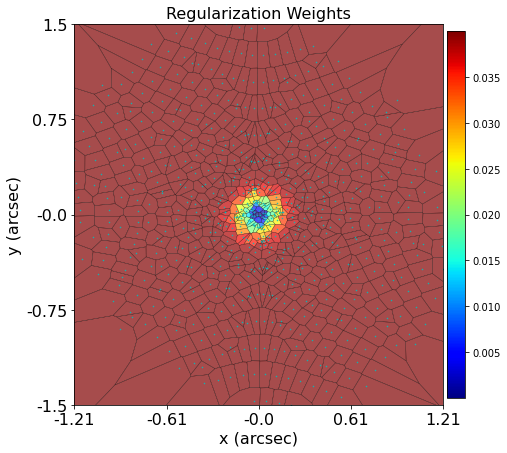

Evidence using adaptive `Regularization`.  3745.544588596651


In [9]:
source_adaptive_regularization = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()

inversion_plotter = fit_imaging_plotter.inversion_plotter_of_plane(plane_index=1)
inversion_plotter.figures(reconstruction=True, regularization_weights=True)

print("Evidence using adaptive `Regularization`. ", fit.log_evidence)

To end, lets consider what this adaptive `Regularization` scheme means in the context of maximizing the Bayesian
log_evidence. In the previous tutorial, we noted that by using a brightness-based adaptive `Pixelization` we increased 
the Bayesian log evidence by allowing for new solutions which fit the data user fewer source pixels; the key criteria 
in making a source reconstruction `more simple` and `less complex`.

As you might of guessed, adaptive `Regularization`.gain increases the Bayesian log evidence by making the source 
reconstruction simpler:

 1) Reducing `Regularization` in the source's brightest regions produces a `simpler` solution in that we are not 
 over-smoothing our reconstruction of its brightest regions.
    
 2) Increasing `Regularization` in the outskirts produces a simpler solution by correlating more source-pixels, 
 effectively reducing the number of pixels used by the reconstruction.

Together, brightness based `Pixelization`'s and `Regularization` allow us to find the objectively `simplest` source 
solution possible and therefore ensure that our Bayesian log evidence`s have a well defined maximum value they are 
seeking. This was not the case for magnification based `Pixelization`'s and constant `Regularization` schemes.